# Exploratory Data Analysis (EDA)

## Table of Contents
1. [Dataset Overview](#dataset-overview)
2. [Handling Missing Values](#handling-missing-values)
3. [Feature Distributions](#feature-distributions)
4. [Possible Biases](#possible-biases)
5. [Correlations](#correlations)


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

from Data.load_data import get_energy_data

## Dataset Overview

[Provide a high-level overview of the dataset. This should include the source of the dataset, the number of samples, the number of features, and example showing the structure of the dataset.]


In [2]:
df = get_energy_data()

# Number of samples
num_samples = df.shape[0]

# Number of features
num_features = df.shape[1]

# Display these dataset characteristics
print(f"Number of samples: {num_samples}")
print(f"Number of features: {num_features}")

# Display the first few rows of the dataframe to show the structure
print("Example data:")
print(df.head())

Number of samples: 26280
Number of features: 2
Example data:
                               Load  Temperature
Date (UTC)                                      
2016-12-31 23:00:00+00:00  188528.8         -2.2
2017-01-01 00:00:00+00:00  183256.4         -2.4
2017-01-01 01:00:00+00:00  177785.3         -2.5
2017-01-01 02:00:00+00:00  172906.9         -2.7
2017-01-01 03:00:00+00:00  169715.8         -2.8


## Handling Missing Values

In [3]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values


Load           0
Temperature    0
dtype: int64

No missing values found!

## Feature Distributions

[Plot the distribution of various features and target variables. Comment on the skewness, outliers, or any other observations.]


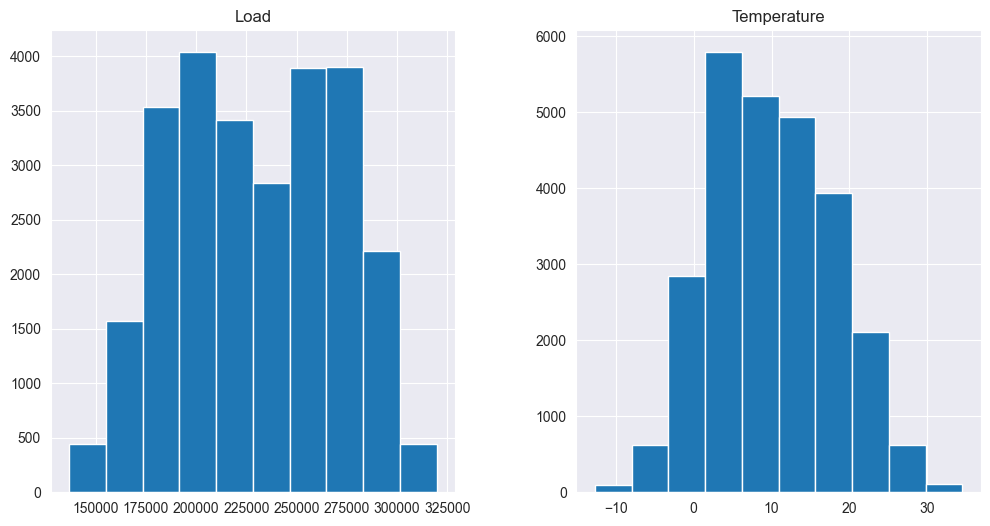

In [6]:
# Example: Plotting histograms of all numerical features
df.hist(figsize=(12, 6))
plt.show()

## Possible Biases

[Investigate the dataset for any biases that could affect the model’s performance and fairness (e.g., class imbalance, historical biases).]


In [ ]:
# Example: Checking for class imbalance in a classification problem
# sns.countplot(x='target_variable', data=df)

# Your code to investigate possible biases goes here


## Correlations

[Explore correlations between features and the target variable, as well as among features themselves.]


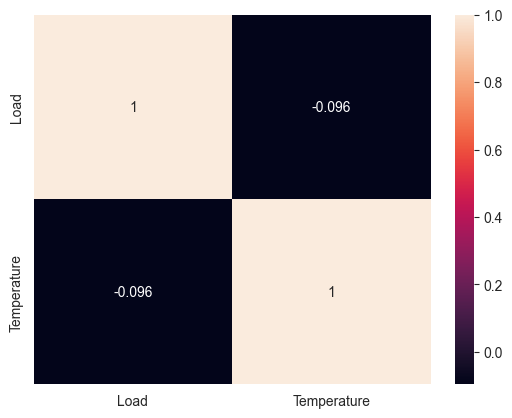

In [4]:
# Example: Plotting a heatmap to show feature correlations
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()
